In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets
from scipy.spatial.distance import cdist

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
cmap = colors.ListedColormap(['orange', 'red'])
cmap_green = colors.ListedColormap(['green', 'red'])
cmap_pink = colors.ListedColormap(['pink', 'red'])

In [3]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

In [4]:
folders_list = sorted(os.listdir(train_folder))
folders_list.remove('board_logs')
folders_list.remove('archive')
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(folder_dropdown)

Dropdown(description='source: ', index=11, options=('2017_09_21_19_08_34', '2017_10_20_12_11_54', '2017_10_20_…

In [22]:
labels = sorted(glob.glob(os.path.join(train_folder, folder_dropdown.value, 'validation_predictions') + '/*_label.nrrd'))
print('no of labels: {}'.format(len(labels)))
labels_dropdown = widgets.Dropdown(
    options=labels,
    value=labels[0],
    description='label: ',
)
display(labels_dropdown)

no of labels: 2


Dropdown(description='label: ', options=('/media/mehrtash/mehrtash2/qanat/intermediate/train/2018_02_16_21_23_…

In [29]:
label_path = labels_dropdown.value
image = sitk.ReadImage(label_path.replace('_label.nrrd', '.nrrd'))
image_nda = sitk.GetArrayFromImage(image)
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label)
label_nda = np.ma.masked_where(label_nda== 0, label_nda)
pred = sitk.ReadImage(label_path.replace('_label.nrrd', '_pred.nrrd'))
pred_nda = sitk.GetArrayFromImage(pred)

In [30]:
print(np.amax(pred_nda))

529.0


In [31]:
lower_bound_th = 300
pred_th = sitk.BinaryThreshold(pred, lower_bound_th, 1000, 1, 0)

In [32]:
pred_nda = sitk.GetArrayFromImage(pred_th)
np.amax(pred_nda)

1

In [33]:
'''
threshold = 100
pred_nda[pred_nda<threshold] = 0
pred_nda[pred_nda>=threshold] = 1
pred_nda = np.ma.masked_where(pred_nda== 0, pred_nda)
'''

'\nthreshold = 100\npred_nda[pred_nda<threshold] = 0\npred_nda[pred_nda>=threshold] = 1\npred_nda = np.ma.masked_where(pred_nda== 0, pred_nda)\n'

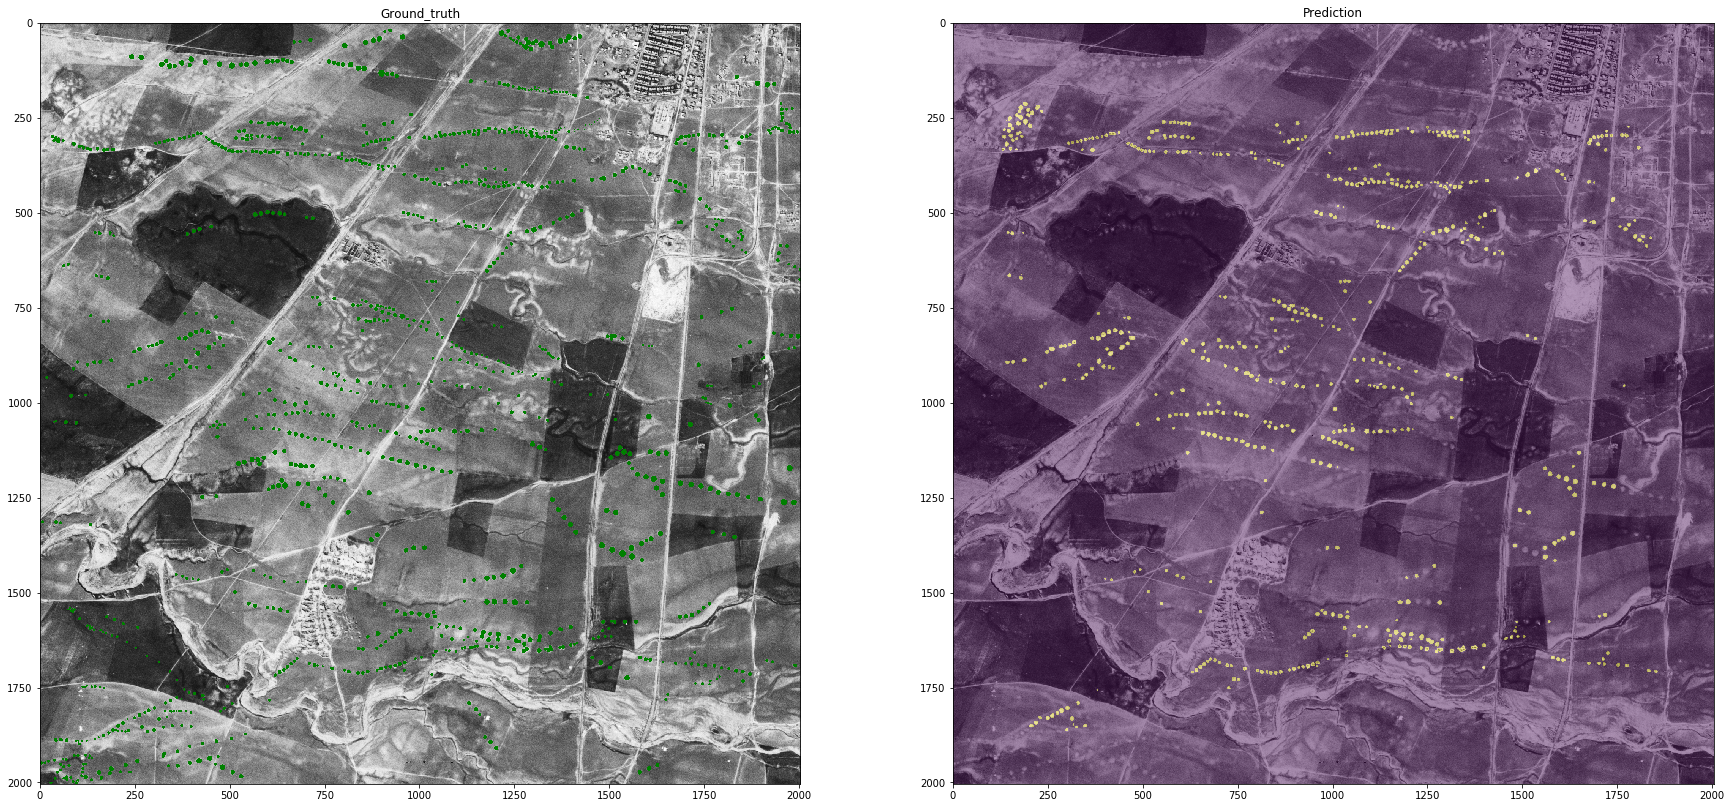

In [34]:
plt.figure(figsize=(30,30))
plt.subplot(121)
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.imshow(label_nda, alpha=1, cmap=cmap_green)
plt.title('Ground_truth')
plt.subplot(122)
plt.title('Prediction')
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.imshow(pred_nda, alpha=0.4)

In [35]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap_true = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap_true, ccf_labelmap_true)
labels_true= list(stats_filter.GetLabels())
labels_true.remove(0)
#
ccf_labelmap_pred = ccf.Execute(pred_th)
stats_filter.Execute(ccf_labelmap_pred, ccf_labelmap_pred)
labels_pred = list(stats_filter.GetLabels())
labels_pred.remove(0)

In [36]:
print(len(labels_true))
print(len(labels_pred))

1070
567


In [37]:
def get_centroid(ccf_labelmap):
    stats_filter = sitk.LabelStatisticsImageFilter()
    stats_filter.Execute(ccf_labelmap, ccf_labelmap)
    labels = list(stats_filter.GetLabels())
    labels.remove(0)
    shape_stats_filter = sitk.LabelShapeStatisticsImageFilter()
    shape_stats_filter.SetBackgroundValue(0)
    shape_stats_filter.ComputeFeretDiameterOn()
    shape_stats_filter.Execute(ccf_labelmap)
    centroids = np.zeros((len(labels), 2))
    for index, label_val in enumerate(labels):
        centroids[index,0], centroids[index,1]  = shape_stats_filter.GetCentroid(label_val)
    return labels, centroids

In [38]:
pred_labels, pred_centroid = get_centroid(ccf_labelmap_pred)
true_labels, true_centroid = get_centroid(ccf_labelmap_true)

In [39]:
distances = cdist(true_centroid, pred_centroid)

In [40]:
distances.shape

(1070, 567)

In [41]:
neighbors_true = np.argmin(distances, axis=0)+1
neighbors_pred = np.argmin(distances, axis=1)+1

In [42]:
def dice_coefficient(label_true, label_pred, label_val_true, label_val_pred):
    nda_true = sitk.GetArrayFromImage(label_true)
    nda_pred = sitk.GetArrayFromImage(label_pred)
    nda_true[nda_true != label_val_true] = 0
    nda_true[nda_true == label_val_true] = 1
    nda_pred[nda_pred != label_val_pred] = 0
    nda_pred[nda_pred == label_val_pred] = 1
    y_true = nda_true.flatten()
    y_pred = nda_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

In [43]:
print(neighbors_true)
print(len(neighbors_true))
print(neighbors_pred)
print(len(neighbors_pred))

[215 215 215 215 215 215 216 212 215  87 212  89  89  90 216  94  92 212
 215  97 102 163 109 208 122 117 212 121 127 134 126 130 131 132 159 143
 136 144 128 133 149 135 178 148 139 216 142 146 151 150 155 157 153 212
 161 159 152 187 164 162 208 215 168 165 171 181 183 170 162 173 175 177
 179 184 169 185 182 216 188 190 170 194 192 212 191 193 196 193 199 200
 212 204 198 201 198 211 212 213 185 208 216 193 218 211 219 220 211 225
 222 223 224 226 232 228 180 230 231 232 233 234 238 241 242 243 245 244
 248 256 259 252 252 261 280 264 262 265 266 267 285 262 274 270 268 271
 272 277 275 279 276 280 278 281 283 285 282 282 284 286 287 289 290 287
 288 291 297 281 290 293 294 295 290 297 296 297 301 315 322 303 305 303
 309 312 314 315 316 326 323 325 326 327 316 329 332 335 334 336 337 316
 337 327 341 339 343 335 345 346 347 343 348 327 353 355 327 354 355 327
 358 335 357 358 361 362 319 312 366 316 312 367 369 373 376 377 379 379
 381 381 382 383 384 384 387 388 394 389 393 394 39

In [44]:
dc_true = np.zeros(len(neighbors_true))
for index, neighbor in enumerate(neighbors_true):
    dc_true[index] = dice_coefficient(ccf_labelmap_true, ccf_labelmap_pred, neighbor, index+1)

In [45]:
dc_pred = np.zeros(len(neighbors_pred))
for index, neighbor in enumerate(neighbors_pred):
    dc_pred[index] = dice_coefficient(ccf_labelmap_true, ccf_labelmap_pred, index+1, neighbor)

In [46]:
dice_threshold = 0
tp = np.sum(dc_true>dice_threshold)
fn = np.sum(dc_true<=dice_threshold)
print('true positive: {}'.format(tp))
print('false negative: {}'.format(fn))

true positive: 464
false negative: 103


In [47]:
dice_threshold = 0
fp = np.sum(dc_pred<=dice_threshold)
print('false positives: {}'.format(fp))

false positives: 613


In [48]:
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
f1 = (2*tp)/ (2*tp + fp +fn)
print('precision: {0:0.2f}, recall: {1:0.2f}, f1: {2:0.2f}'.format(precision, recall, f1))

precision: 0.43, recall: 0.82, f1: 0.56
